# **1. Set up**

In [1]:
import os
!git clone https://github.com/TieuLongPhan/Database.git
os.chdir("/content/Database/Training_cheminformatics")

Cloning into 'Database'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 19 (delta 2), reused 15 (delta 1), pack-reused 0
Unpacking objects: 100% (19/19), 734.83 KiB | 4.77 MiB/s, done.


In [2]:
!pip install rdkit-pypi mols2grid tqdm umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.0/97.0 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.1 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=f2e36f020eaabcb01b72b8148ce7df0d469c037ff33601a3513331c091564ed3
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=5fdfef3b6d489bb56a590cd82fb215a95b38dd898b2da1e178f58a559d

In [3]:
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
from io import BytesIO
import pandas as pd
import numpy as np
from IPython.display import SVG

# RDKit 
import rdkit
from rdkit import Chem #RDKit Chemistry
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdRGroupDecomposition
from rdkit.Chem.Draw import IPythonConsole #RDKit drawing
from rdkit.Chem import Draw #RDKit drawing
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed if modifying defaults


# A few settings to improve the quality of structures 
from rdkit.Chem import rdDepictor
DrawingOptions.bondLineWidth=1.8
IPythonConsole.ipython_useSVG=True
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem import PandasTools #Add the ability to add a molecule to a dataframegrid
import mols2grid #The mols2grid library provides a convenient way of displaying molecules in a grid

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.warning')
tqdm.pandas()

# **2. Data processing**

In [4]:
df = pd.read_csv("EGFR_compounds.csv").drop('Unnamed: 0', axis =1)
df.head(2)

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849


In [5]:
df['bin'] = 'Inactive'
df.loc[df['pIC50'] > 7,'bin'] = 'Active'
df.head(2)

,molecule_chembl_id,IC50,units,smiles,pIC50,bin
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,Active
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,Active


# **3. Descriptors**

In [ ]:
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
def smil2rdk(mol):
    des_list = [x[0] for x in Descriptors._descList]
    calculator = MoleculeDescriptors.MolecularDescriptorCalculator(des_list)
    d = calculator.CalcDescriptors(mol)
    return d

PandasTools.AddMoleculeColumnToFrame(df,'smiles','Molecule')

df["RDK"] = df.Molecule.progress_apply(smil2rdk)

X_rdk = np.stack(df['RDK'])
data = pd.DataFrame(X_rdk, columns = [x[0] for x in Descriptors._descList])

df2 = pd.concat([df, data], axis = 1)
df2.drop(["RDK"], axis =1, inplace = True)
display(df2.head(3))

100%|██████████| 5568/5568 [02:26<00:00, 38.10it/s]


,molecule_chembl_id,IC50,units,smiles,pIC50,bin,Molecule,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,Active,<rdkit.Chem.rdchem.Mol object at 0x7fb5745c4350>,4.401118,0.813753,4.401118,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,Active,<rdkit.Chem.rdchem.Mol object at 0x7fb5745c43c0>,5.706147,0.563160,5.706147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,Active,<rdkit.Chem.rdchem.Mol object at 0x7fb5745c4430>,4.369027,0.767222,4.369027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df3 = df2.drop(["smiles", "molecule_chembl_id", "IC50", 'units', 'Molecule'], axis = 1)
df3.dropna(inplace = True)
df2.reset_index(drop = True, inplace = True)
df3.head(2)

,pIC50,bin,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,11.522879,Active,4.401118,0.813753,4.401118,0.813753,0.499383,350.219,338.123,349.021459,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11.221849,Active,5.706147,0.563160,5.706147,0.563160,0.648824,388.265,370.121,387.058239,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **4. Visualization tools**

## 4.1. Histogram - KDE

Plot a frequency distribution using Seaborn's [displot](https://seaborn.pydata.org/generated/seaborn.displot.html)

Experiment with
- kind = "kde"
- kind = "hist"

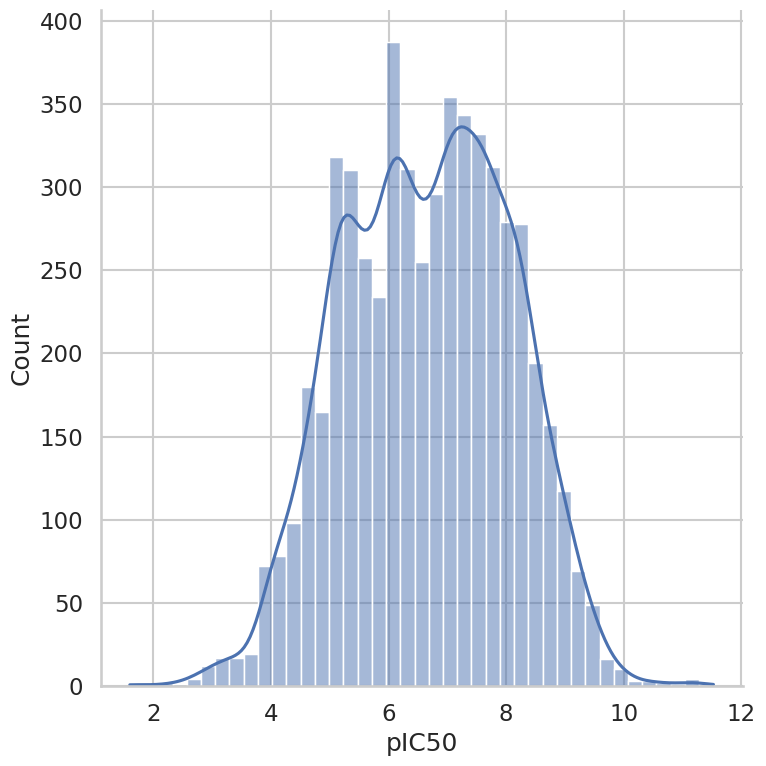

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize': (10, 10)})
sns.set_style('whitegrid')
sns.set_context('talk')
sns.displot(df3.pIC50, kind = 'hist', kde = True, height = 8)

Histogram

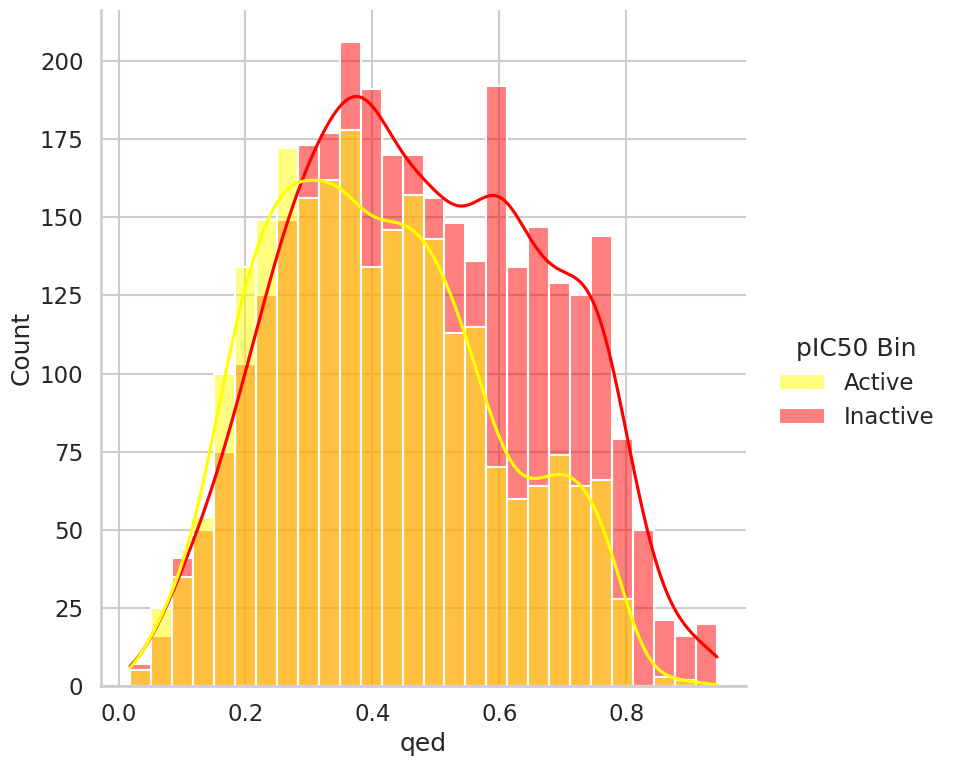

In [ ]:
color_map_3 = {"Inactive":"red","Active":"yellow"}
g = sns.displot(x="qed",kind="hist",kde=True, height=8, hue="bin",data=df3,palette=color_map_3)
g.fig.legends[0].set_title("pIC50 Bin")

## 4.2. Boxplot

Text(0.5, 0, 'pIC50 Bin')

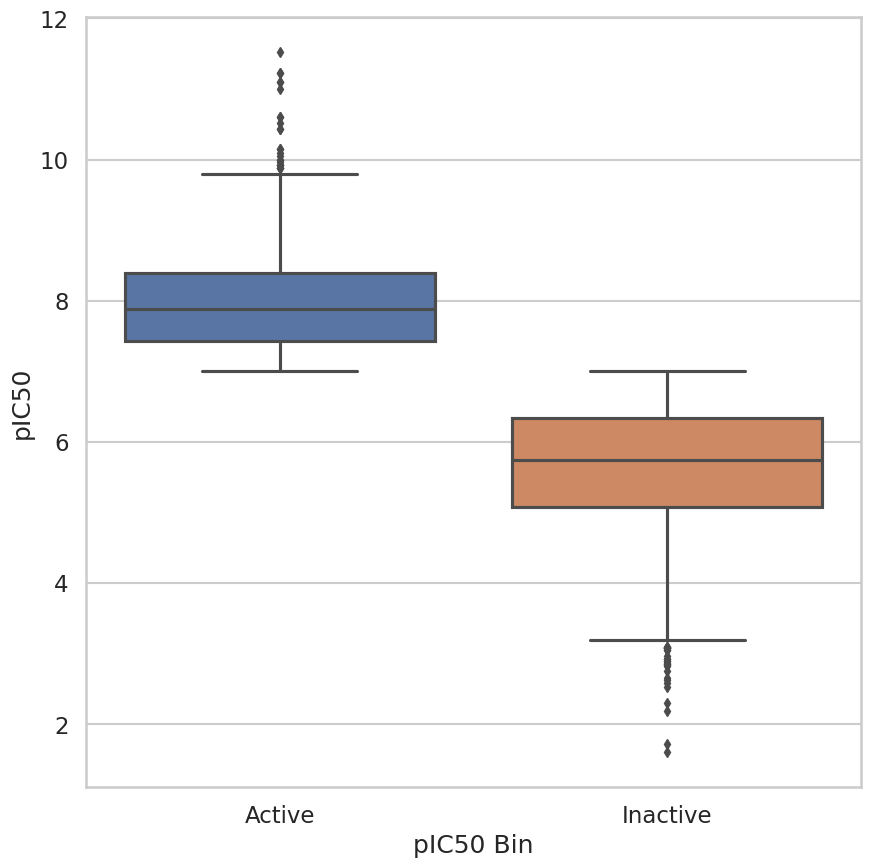

In [ ]:
ax = sns.boxplot(x="bin",y="pIC50",data=df)
ax.set_xlabel("pIC50 Bin")

Text(0.5, 0, 'pIC50 Bin')

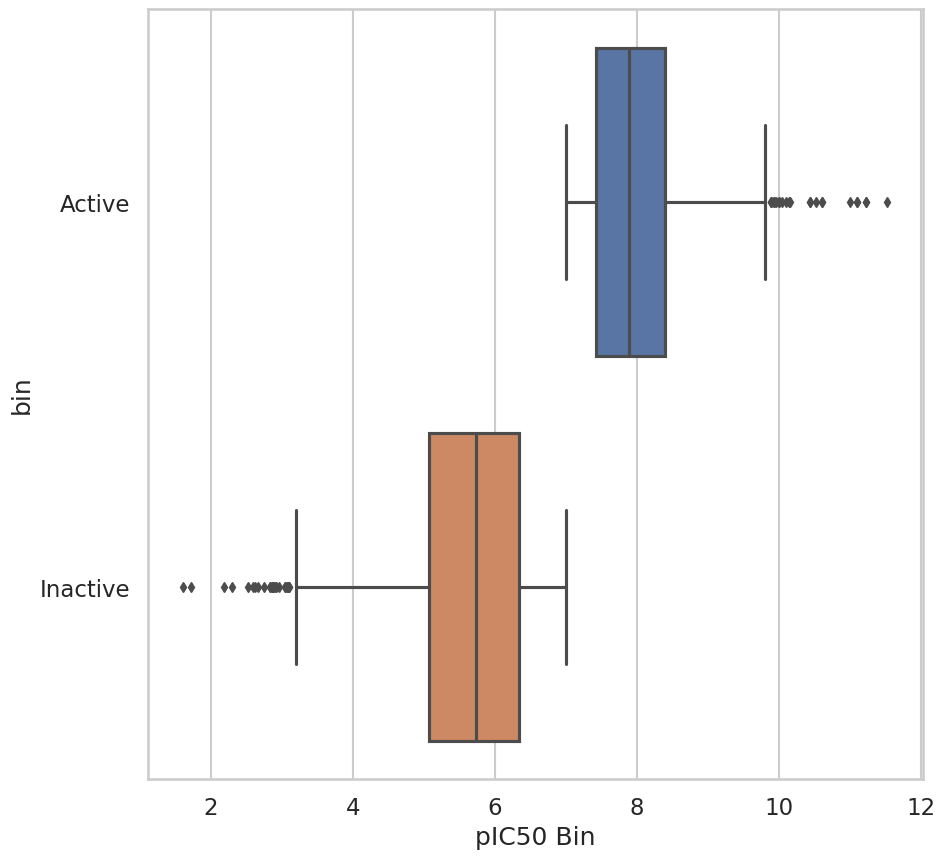

In [ ]:
ax = sns.boxplot(y="bin",x="pIC50",data=df)
ax.set_xlabel("pIC50 Bin")

Boxplot for Outlier detection

<Axes: xlabel='MaxEStateIndex', ylabel='bin'>

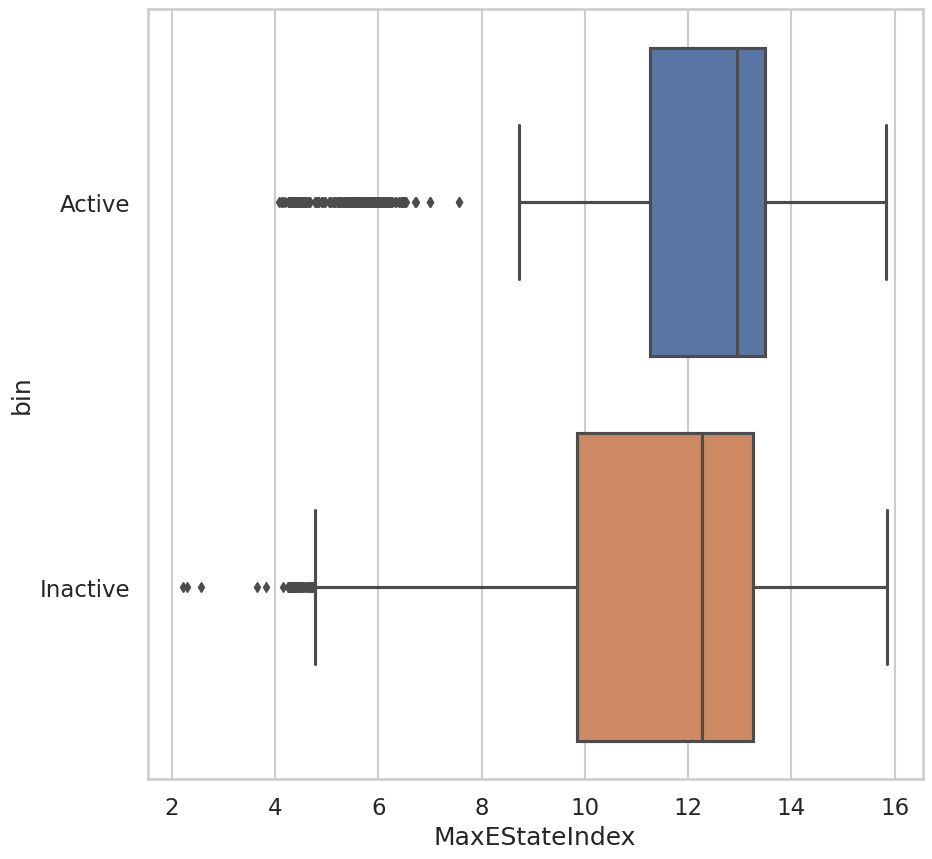

In [ ]:
sns.boxplot(data = df3, x = 'MaxEStateIndex', y = 'bin')

<Axes: xlabel='MaxEStateIndex', ylabel='bin'>

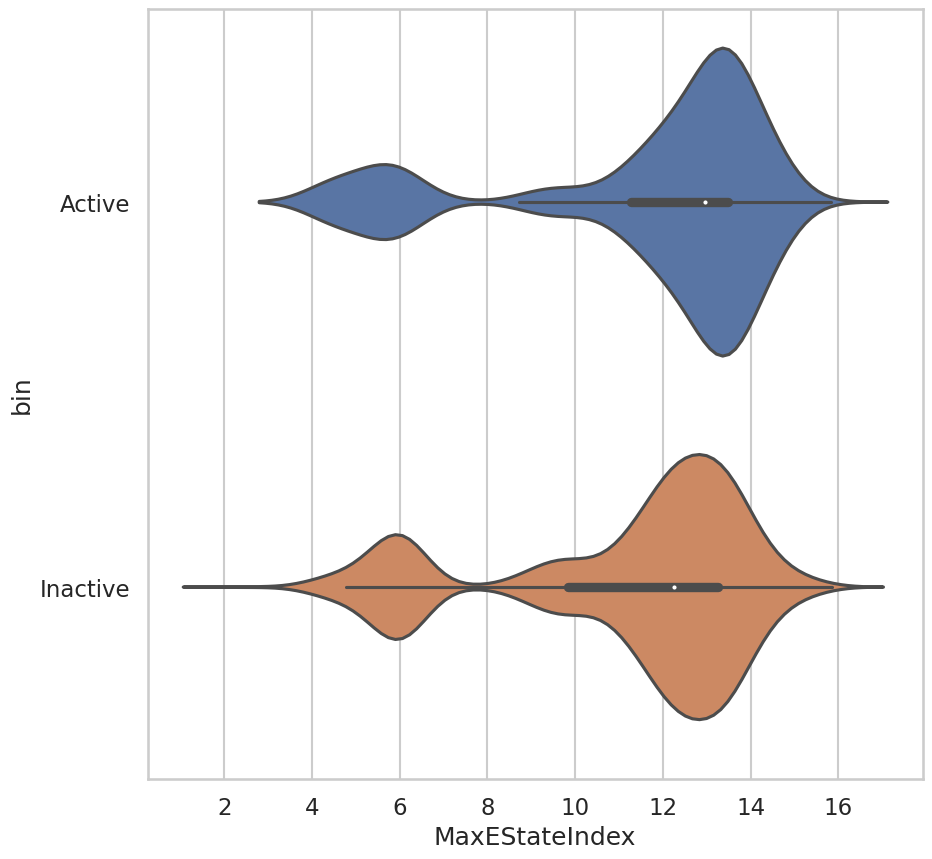

In [ ]:
sns.violinplot(data = df3, x = 'MaxEStateIndex', y = 'bin')

## 4.3. Bar plot

<Axes: xlabel='bin', ylabel='pIC50'>

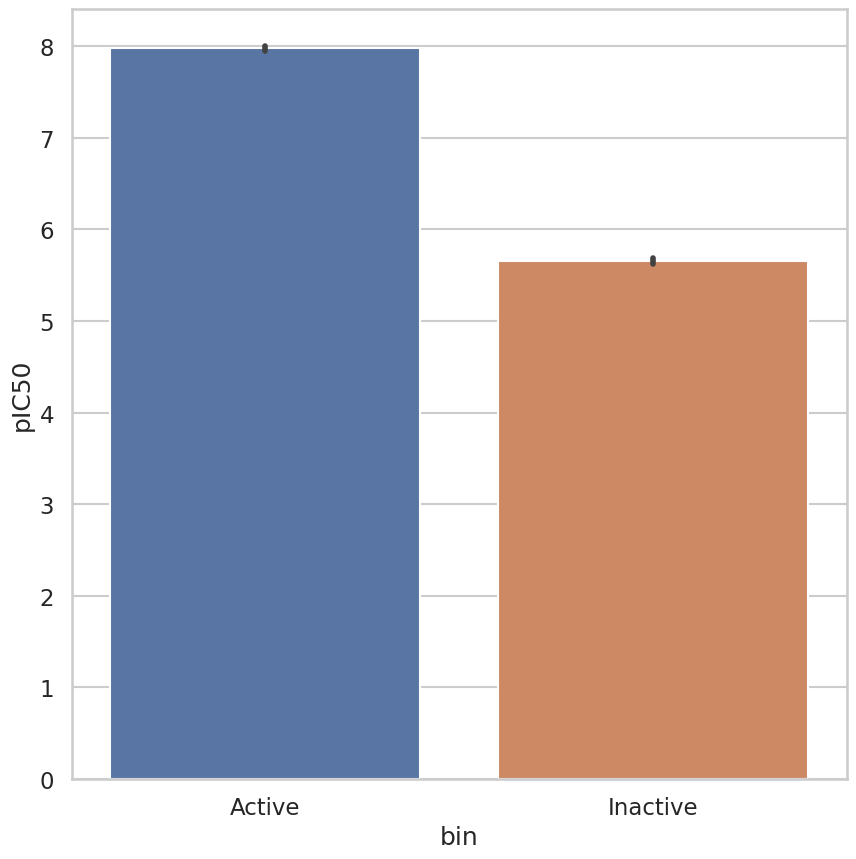

In [ ]:
import seaborn as sns
sns.barplot(data = df3, x = df3.bin, y = df3.pIC50,)

In [ ]:
df2.columns

Index(['molecule_chembl_id', 'IC50', 'units', 'smiles', 'pIC50', 'bin',
       'Molecule', 'MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex',
       ...
       'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene',
       'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene',
       'fr_unbrch_alkane', 'fr_urea'],
      dtype='object', length=215)

<Axes: xlabel='bin', ylabel='qed'>

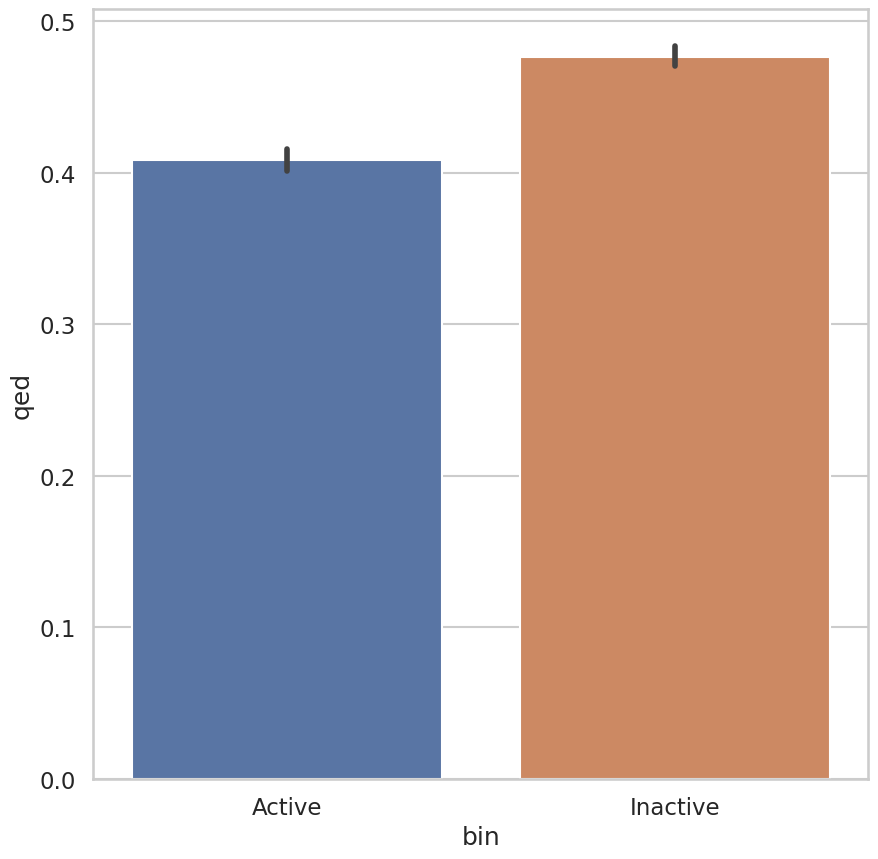

In [ ]:
sns.barplot(data = df3, x = df3.bin, y = df3.qed,)

## 4.4. Line plot

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
desc_columns = [x[0] for x in Descriptors._descList]
scaler = MinMaxScaler()
scaled_descriptors = scaler.fit_transform(df3[desc_columns])
des = pd.DataFrame(scaled_descriptors, columns = desc_columns)
df4 = pd.concat([df3.iloc[:,:2], des], axis = 1)
df4.head(2)

,pIC50,bin,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,11.522879,Active,0.160386,0.947840,0.160386,0.700626,0.520347,0.109795,0.117660,0.109349,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11.221849,Active,0.256029,0.910249,0.256029,0.484870,0.681959,0.127193,0.133745,0.126753,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X = scaled_descriptors
X.shape

(5559, 208)

In [ ]:
y = df3.pIC50.values
y.shape

(5559,)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state = 42)
model.fit(X, y)

RandomForestRegressor(random_state=42)

In [ ]:
data_2 = pd.DataFrame([y, model.predict(X)], index = ["Truth", "Pred"]).T

In [ ]:
data_2.head(2)

,Truth,Pred
0,11.522879,9.917246
1,11.221849,10.439948


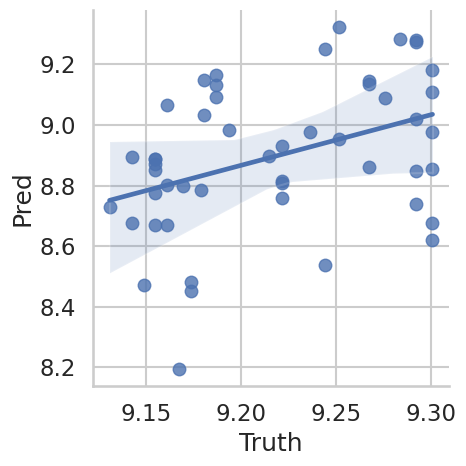

In [ ]:
sns.lmplot(x = 'Truth',
            y = 'Pred', 
            ci = 100, data = data_2.iloc[100:150,:])

## 4.5. tsne

Use Truncated Stochastic Neighbor Embedding ([TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)) to view the relationship between activity and our descriptors. 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
desc_columns = [x[0] for x in Descriptors._descList]
scaler = StandardScaler()
scaled_descriptors = scaler.fit_transform(df3[desc_columns])
des = pd.DataFrame(scaled_descriptors, columns = desc_columns)
df4 = pd.concat([df3.iloc[:,:2], des], axis = 1)
df4.head(2)

,pIC50,bin,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,11.522879,Active,-2.331778,1.137609,-2.331778,3.263982,0.274870,-0.844136,-0.799685,-0.850010,...,-0.203985,-0.169934,-0.160284,-0.151047,-0.052016,-0.178686,0.0,-0.259975,-0.273455,-0.248779
1,11.221849,Active,-1.893708,0.941777,-1.893708,1.972732,1.058724,-0.501446,-0.494116,-0.506904,...,-0.203985,-0.169934,-0.160284,-0.151047,-0.052016,-0.178686,0.0,-0.259975,-0.273455,-0.248779


In [ ]:
scaled_descriptors

array([[-2.33177756,  1.1376094 , -2.33177756, ..., -0.25997532,
        -0.27345532, -0.24877925],
       [-1.89370834,  0.94177738, -1.89370834, ..., -0.25997532,
        -0.27345532, -0.24877925],
       [-2.34254996,  1.10124684, -2.34254996, ..., -0.25997532,
        -0.27345532, -0.24877925],
       ...,
       [-0.79637036,  0.02739963, -0.79637036, ..., -0.25997532,
        -0.27345532, -0.24877925],
       [ 0.35101566, -0.85482388,  0.35101566, ..., -0.25997532,
        -0.27345532, -0.24877925],
       [ 0.21459488,  0.15306044,  0.21459488, ..., -0.25997532,
        -0.27345532, -0.24877925]])

In [ ]:
tsne = TSNE()
tsne_crds = tsne.fit_transform(scaled_descriptors)

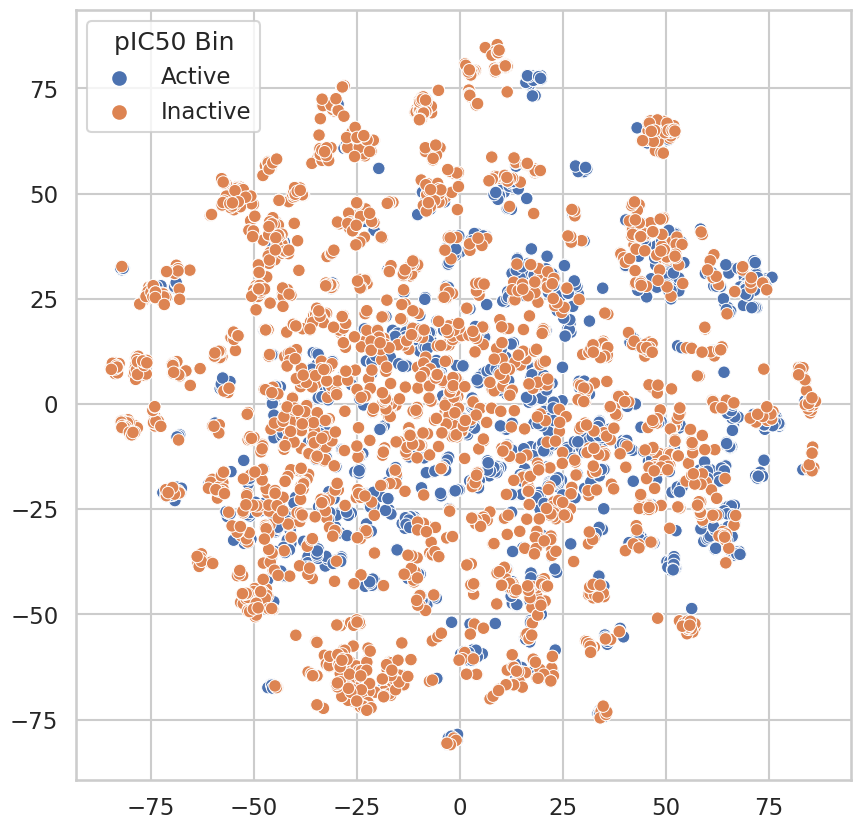

In [ ]:
ax = sns.scatterplot(x=tsne_crds[:,0],y=tsne_crds[:,1],hue=df3.bin,)
ax.get_legend().set_title("pIC50 Bin")

## 4.6. umap

Some will argue that [Uniform Manifold Approximation](https://umap-learn.readthedocs.io/en/latest/) (UMAP) is a better way to do this. I'm not particularly partial to either, but here's how to do the same thing with UMAP.  As you can see, the APIs are very similar. 

In [ ]:
from umap import UMAP
umap = UMAP(n_neighbors=30)
umap_crds = umap.fit_transform(scaled_descriptors)

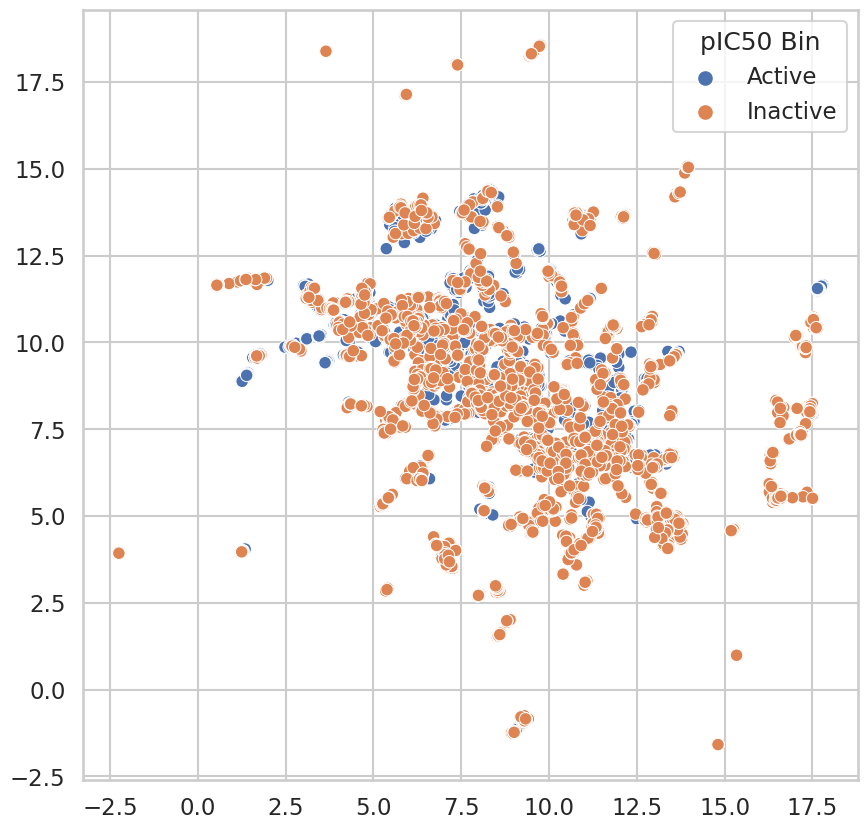

In [ ]:
ax = sns.scatterplot(x=umap_crds[:,0],y=umap_crds[:,1],hue=df3.bin)
ax.get_legend().set_title("pIC50 Bin")

# **5. Visualize with Chemplot**
Please read the document of [Chemplot](https://chemplot.readthedocs.io/en/latest/user_manual/similarity.html)